In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import numpy as np
import matplotlib.pyplot as plt
from phantom_functions import create_ptycho_phantom, calculate_wavelength, read_probe_positions_new, convert_positions_to_pixels,set_object_size_pxls, load_data, get_simulated_data, read_probe_positions_in_pxls
# from ptycho_functions import RAAR_loop, mPIE_loop,RAAR_multiprobe_loop,PIE_multiprobe_loop, plot_results3, plot_probe_modes, plot_guess_and_model, get_circular_mask

/ibira/lnls/labs/tepui/apps/modules/python/3.9.2/lib/python3.9/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.0.1. is an invalid version and will not be supported in a future release
  warnings.warn(
/ibira/lnls/labs/tepui/apps/modules/python/3.9.2/lib/python3.9/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.0.0. is an invalid version and will not be supported in a future release
  warnings.warn(


In [47]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import time
from tqdm import tqdm

from sscPimega import misc

import random
random.seed(0)

from numpy.fft import fft2, fftshift, ifftshift, ifft2

def plot_guess_and_model(model_obj,model_probe,obj_guess,probe_guess,positions):
    from matplotlib.patches import Rectangle
    from sscMisc.plots import convert_complex_to_RGB

    colormap = 'viridis'
    colormap2 = 'hsv'    
    figure, ax = plt.subplots(2,5,dpi=150,figsize=(15,5))
    count = -1
    # for i,ax0 in enumerate(ax.reshape(-1)):
        # ax0.set_yticks([]), ax0.set_xticks([])
    ax[0,0].imshow(np.abs(model_obj),cmap=colormap)
    ax[0,0].set_title("Obj Abs")
    ax[0,1].imshow(np.angle(model_obj),cmap=colormap2)
    ax[0,1].set_title("Obj Phase")
    ax[0,2].imshow(np.abs(model_probe),cmap=colormap)
    ax[0,2].set_title("Probe Abs")
    ax[0,3].imshow(np.angle(model_probe),cmap=colormap2)
    ax[0,3].set_title("Probe Phase")
    ax[1,0].imshow(np.abs(obj_guess),cmap=colormap)
    ax[1,0].set_title("Obj Guess")
    ax[1,1].imshow(np.angle(obj_guess),cmap=colormap2)
    ax[1,1].set_title("Obj Guess")
    ax[1,2].imshow(np.abs(probe_guess),cmap=colormap)
    ax[1,2].set_title("Probe Guess")
    ax[1,3].imshow(np.angle(probe_guess),cmap=colormap2)
    ax[1,3].set_title("Probe Guess")
    
    data_rgb = convert_complex_to_RGB(model_obj)
    ax[0,4].imshow(data_rgb)
    cmap = plt.get_cmap('jet',positions.shape[0])
    mycm = cmap(np.arange(0,positions.shape[0]+1,1))
    for i, (x,y) in enumerate(positions):
        rect = Rectangle((y,x),probe_guess.shape[1],probe_guess.shape[0],linestyle='-',linewidth=1,edgecolor=mycm[i],facecolor='none',alpha=1)
        ax[0,4].add_patch(rect)
    ax[1,4].axis('off')
    ax[0,4].set_title("Scan region")
    figure.tight_layout()

def plot_results(model_obj,probe_guess,RAAR_obj, RAAR_probe, RAAR_error, RAAR_time,PIE_obj, PIE_probe, PIE_error, PIE_time):
    colormap = 'jet'    
    figure, ax = plt.subplots(3,5,dpi=150,figsize=(10,6))
    count = -1
    for i,ax0 in enumerate(ax.reshape(-1)):
        count += 1
        if count == 5: 
            ax0.grid()
            continue
        ax0.set_yticks([])
        ax0.set_xticks([])
    ax[0,0].imshow(np.sum(difpads,axis=0),norm=LogNorm(),cmap=colormap)
    ax[0,0].set_title("_sum of difpads")
    ax[0,1].imshow(np.abs(model_obj),cmap=colormap)
    ax[0,1].set_title("Magnitude")
    ax[0,2].imshow(np.angle(model_obj),cmap=colormap)
    ax[0,2].set_title("Phase")
    ax[0,3].imshow(np.abs(probe_guess),cmap=colormap)
    ax[0,3].set_title("Magnitude")
    ax[0,4].imshow(np.angle(probe_guess),cmap=colormap)
    ax[0,4].set_title("Phase")
    ax[1,0].plot(RAAR_error,'.-',label='RAAR')
    ax[1,1].imshow(np.abs(RAAR_obj),cmap=colormap)
    ax[1,2].imshow(np.angle(RAAR_obj),cmap=colormap)
    ax[1,3].imshow(np.abs(RAAR_probe),cmap=colormap)
    ax[1,4].imshow(np.angle(RAAR_probe),cmap=colormap)
    ax[0,0].set_ylabel('Model')
    ax[1,0].set_ylabel('RAAR')
    ax[2,0].set_ylabel('mPIE')
    ax[1,0].plot(PIE_error,'.-',label='PIE')
    ax[2,1].imshow(np.abs(PIE_obj),cmap=colormap)
    crop = 25
    ax[2,0].imshow(np.abs(PIE_obj[crop:-crop,crop:-crop]),cmap=colormap)
    ax[2,2].imshow(np.angle(PIE_obj),cmap=colormap)
    ax[2,3].imshow(np.abs(PIE_probe),cmap=colormap)
    ax[2,4].imshow(np.angle(PIE_probe),cmap=colormap)
    ax[1,0].legend()
    figure.tight_layout()
    

def PIE_update_obj_and_probe(mPIE_params,difference,probe,obj,px,py,offset,iteration,use_rPIE_update_function=True,i_to_start_p_update=50,beta=100,centralize_probe = False):
    alpha,beta,gamma_obj,gamma_prb,eta_obj,eta_probe,T_lim = mPIE_params
    obj_box = obj[py:py+offset[0],px:px+offset[1]]

    if iteration > 10:    
        centralize_probe = False
    if centralize_probe:
        centralization_weight = get_circular_mask(probe.shape[0],0.1,invert=True)

    if use_rPIE_update_function: # rPIE update function
        obj_box = obj_box + gamma_obj*difference*probe.conj()/ ( (1-alpha)*np.abs(probe)**2+alpha*(np.abs(probe)**2).max() )

        if iteration > i_to_start_p_update:
            if centralize_probe:
                probe = probe + gamma_prb*(difference*obj_box.conj() - centralization_weight*probe)/ ( (1-beta) *np.abs(obj_box)**2+beta *(np.abs(obj_box)**2).max() + centralization_weight)
            else:
                probe = probe + gamma_prb*(difference*obj_box.conj())/ ( (1-beta) *np.abs(obj_box)**2+beta *(np.abs(obj_box)**2).max())
    
    obj[py:py+offset[0],px:px+offset[1]] = obj_box
    
    return obj, probe, obj_box

def set_object_pixel_size(jason,half_size):
    c = 299792458             # Speed of Light [m/s]
    planck = 4.135667662E-18  # Plank constant [keV*s]
    wavelength = planck * c / jason['Energy'] # meters
    jason["wavelength"] = wavelength
    # Convert pixel size:
    dx = wavelength * jason['DetDistance'] / ( jason['Binning'] * jason['RestauredPixelSize'] * half_size * 2)
    return dx, jason
    
def apply_random_shifts_to_positions(positionsX,positionsY,mu=0,sigma=3,type='gaussian'):
        if type == 'gaussian':
            deltaX = np.random.normal(mu, sigma, positionsX.shape)
            deltaY = np.random.normal(mu, sigma, positionsY.shape)
            # X, Y = np.round(positionsX+deltaX).astype(np.int),np.round(positionsY+deltaY).astype(np.int)
            # X -= np.min(X)
            # Y -= np.min(Y)
            # return X, Y
        elif type=='random':
            deltaX = np.round(sigma*np.random.rand(*positionsX.shape))
            deltaY = np.round(sigma*np.random.rand(*positionsY.shape))
        return positionsX+deltaX, positionsY+deltaY

def get_positions_array(probe_steps_xy,frame_shape,random_positions=True):

    dx, dy = probe_steps_xy # probe step size in each direction
    y_pxls = np.arange(0,frame_shape[0]+1,dy)
    x_pxls = np.arange(0,frame_shape[1]+1,dx)

    if random_positions == True:
        x_pxls,y_pxls = apply_random_shifts_to_positions(x_pxls,y_pxls)

    positionsY,positionsX = np.meshgrid(y_pxls,x_pxls)
    
    if 0: # Plot positions map
        figure, ax = plt.subplots(dpi=100)
        ax.plot(positionsX,positionsY,'x',label='Original')
        ax.set_title('Positions') 
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_aspect('equal')
    
    return positionsX.flatten(),positionsY.flatten()

def apply_invalid_regions(difpad):
    delta = 25
    for i in range(0,difpad.shape[0]):
        difpad[0:difpad.shape[0]:delta] = -1

    for i in range(0,difpad.shape[1]):
        difpad[:,0:difpad.shape[1]:delta] = -1
    return  difpad
    
def get_circular_mask(dimension,radius,invert=False):
    # dimension = 100 # Must be < than object!
    x = np.linspace(-1,1,dimension)
    X,Y = np.meshgrid(x,x)
    if invert == True:
        circular_mask = np.where(X**2 + Y**2 < radius,0,1)  # Probe
    else:
        circular_mask = np.where(X**2 + Y**2 < radius,1,0)  # Probe
    return circular_mask


def add_error_to_positions(positionsX,positionsY):
        mu, sigma = 0, 1 # mean and standard deviation
        deltaX = np.random.normal(mu, sigma, positionsX.shape)
        deltaY = np.random.normal(mu, sigma, positionsY.shape)
        return positionsX+deltaX,positionsY+deltaY     
    
def propagate_beam(wavefront, experiment_params,propagator='fourier'):
    """ Propagate a wavefront using fresnel ou fourier propagator

    Args:
        wavefront : the wavefront to propagate
        dx : pixel spacing of the wavefront input
        wavelength : wavelength of the illumination
        distance : distance to propagate
        propagator (str, optional): 'fresenel' or 'fourier'. Defaults to 'fresnel'.

    Returns:
        output: propagated wavefront
    """    
    
    dx, wavelength,distance = experiment_params 
    
    if propagator == 'fourier':
        if distance > 0:
            output = fftshift(fft2(fftshift(wavefront)))
        else:
            output = ifftshift(ifft2(ifftshift(wavefront)))            
    
    elif propagator == 'fresnel':
    
        ysize, xsize = wavefront.shape
        x_array = np.linspace(-xsize/2,xsize/2-1,xsize)
        y_array = np.linspace(-ysize/2,ysize/2-1,ysize)

        fx = x_array/(xsize)
        fy = y_array/(ysize)

        FX,FY = np.meshgrid(fx,fy)
        # Calculate approx phase distribution for each plane wave component
        w = FX**2 + FY**2 
        # Compute FFT
        F = fftshift(fft2(fftshift(wavefront)))
        # multiply by phase-shift and inverse transform 
        a = np.exp(-1j*np.pi*( distance*wavelength/dx**2)*w)
        output = ifftshift(ifft2(ifftshift(F*a)))

    return output

def calculate_recon_error(model,obj):
    
    if model.shape[0] != obj.shape[0]:
        extra_y = max(model.shape[0],obj.shape[0])-min(model.shape[0],obj.shape[0])

        if model.shape[0] > obj.shape[0]: # conditional to reduce size of bigger object to the same size of the smallest one
            model = model[extra_y//2:-extra_y//2,:]
        else:
            obj = obj[extra_y//2:-extra_y//2,:]
    
    if model.shape[1] != obj.shape[1]:
        extra_x = max(model.shape[1],obj.shape[1])-min(model.shape[1],obj.shape[1])

        if model.shape[1] > obj.shape[1]:
            model = model[:,extra_x//2:-extra_x//2]
        else:
            obj = obj[:,extra_x//2:-extra_x//2]

    error = np.sum(np.abs(model - obj))/model.size
    return error 

def projection_Rspace_RAAR(wavefronts,obj,probe,positions,epsilon):
    probe = RAAR_update_probe(wavefronts, obj, probe.shape,positions, epsilon=epsilon) 
    obj   = RAAR_update_object(wavefronts, probe, obj.shape, positions,epsilon=epsilon)
    return probe, obj

def RAAR_update_object(exit_waves, probe, object_shape, positions,epsilon=0.01):

    m,n = probe.shape
    k,l = object_shape

    probe_sum  = np.zeros((k,l),dtype=complex)
    wave_sum   = np.zeros((k,l),dtype=complex)
    probe_intensity  = np.abs(probe)**2
    probe_conj = np.conj(probe)

    for index, pos in enumerate((positions)):
        # posy, posx = pos[0], pos[1]
        posy, posx = pos[1], pos[0]
        probe_sum[posy:posy + m , posx:posx+n] = probe_sum[posy:posy + m , posx:posx+n] + probe_intensity
        wave_sum[posy:posy + m , posx:posx+n]  = wave_sum[posy:posy + m , posx:posx+n]  + probe_conj*exit_waves[index] 

    object = wave_sum/(probe_sum + epsilon)

    return object


def RAAR_update_probe(exit_waves, obj, probe_shape,positions, epsilon=0.01):
    m,n = probe_shape

    object_sum = np.zeros((m,n),dtype=complex)
    wave_sum = np.zeros((m,n),dtype=complex)
    obj_intensity = np.abs(obj)**2
    obj_conj = np.conj(obj)

    for index, pos in enumerate((positions)):
        # posy, posx = pos[0], pos[1]
        posy, posx = pos[1], pos[0]
        object_sum = object_sum + obj_intensity[posy:posy + m , posx:posx+n]
        wave_sum = wave_sum + obj_conj[posy:posy + m , posx:posx+n]*exit_waves[index]

    probe = wave_sum/(object_sum + epsilon)

    return probe

def projection_Rspace_multiprobe_RAAR(wavefronts,obj,probes,positions,epsilon):
    probes = RAAR_multiprobe_update_probe(wavefronts, obj, probes.shape,positions, epsilon=epsilon) 
    obj   = RAAR_multiprobe_update_object(wavefronts, probes, obj.shape, positions,epsilon=epsilon)
    return probes, obj

def RAAR_multiprobe_update_object(wavefronts, probe, object_shape, positions,epsilon=0.01):

    modes,m,n = probe.shape
    k,l = object_shape

    probe_sum  = np.zeros((k,l),dtype=complex)
    wave_sum   = np.zeros((k,l),dtype=complex)
    probe_intensity  = np.abs(probe)**2
    probe_conj = np.conj(probe)

    for mode in range(modes):
        for index, (posx, posy) in enumerate((positions)):
            probe_sum[posy:posy + m , posx:posx+n] += probe_intensity[mode]
            wave_sum[posy:posy + m , posx:posx+n]  += probe_conj[mode]*wavefronts[index,mode] 

    obj = wave_sum/(probe_sum + epsilon)

    return obj

def RAAR_multiprobe_update_probe(wavefronts, obj, probe_shape,positions, epsilon=0.01):
    
    l,m,n = probe_shape

    object_sum = np.zeros((m,n),dtype=complex)
    wave_sum = np.zeros((l,m,n),dtype=complex)
    
    obj_intensity = np.abs(obj)**2
    obj_conj = np.conj(obj)
    
    for index, (posx, posy) in enumerate(positions):
        object_sum += obj_intensity[posy:posy + m , posx:posx+n] 
        for mode in range(l):
            wave_sum[mode] += obj_conj[posy:posy + m , posx:posx+n]*wavefronts[index,mode]

    probes = wave_sum/(object_sum + epsilon) # epsilon to avoid division by zero. 

    return probes

def update_exit_wave(wavefront,measurement,experiment_params,epsilon=0.01,propagator = 'fourier'):
    wave_at_detector = propagate_beam(wavefront, experiment_params,propagator=propagator)
    wave_at_detector = np.sqrt(measurement)*wave_at_detector/(np.abs(wave_at_detector)+epsilon)
    # wave_at_detector[measurement>=0] = (np.sqrt(measurement)*wave_at_detector/(np.abs(wave_at_detector)))[measurement>=0]
    updated_exit_wave = propagate_beam(wave_at_detector, (experiment_params[0],experiment_params[1],-experiment_params[2]),propagator=propagator)
    return updated_exit_wave

def momentum_addition(T_counter,T_lim,probeVelocity,objVelocity,O_aux,P_aux,obj, probe,eta_obj,eta_probe):
    T_counter += 1 
    if T_counter == T_lim : # T parameter in mPIE paper
        probeVelocity  = probeVelocity*eta_probe + (probe - P_aux)
        objVelocity = objVelocity*eta_obj  + (obj - O_aux)  
        obj = O_aux + objVelocity
        probe = P_aux + probeVelocity 

        O_aux = obj
        P_aux = probe            
        T_counter = 0
    return T_counter,objVelocity,probeVelocity,O_aux,P_aux,obj,probe


def create_correction_masks(N,M,path,bad_points_percentage=0.05,detector='540D',save=True):
    
    invalid_points = np.where(np.random.rand(N,M)>1-bad_points_percentage,1,0)
    
    invalid_grid = np.zeros((N,M))
    if detector == '540D':
        chip_size = N//12
        line_thickness = 1
        
        for i in range(1,12):
            start = int(i*chip_size)
            end = int(i*chip_size + line_thickness)
            invalid_grid[start:end,:] = 1
            invalid_grid[:,start:end] = 1
    
    mask = invalid_grid+invalid_points
    mask = np.where(mask>0,1,0)
    
    empty = np.zeros_like(invalid_points)
    empty[N//20:N//10,M//20:M//10] = 1
    empty[-N//10:-N//20,M//20:M//10] = 1
    empty[-N//10:-N//20,-M//10:-M//20] = 1

    flatfield = np.ones_like(invalid_points)
    
    total = empty+flatfield+invalid_grid+invalid_points
    total = np.where(total>1,1,0)
    
    if save:
        masks_path = os.path.join(path,'images')
        if not os.path.exists(masks_path):
            os.makedirs(masks_path)
        files = ['flat.hdf5','mask.hdf5','empty.hdf5']
        datasets = [flatfield, mask, empty]
        for file,data in zip(files,datasets):
            savepath = os.path.join(masks_path,file)
            print("Saving data at: ",savepath)
            h5f = h5py.File(savepath, 'w')
            h5f.create_dataset(savepath, data=data)
            h5f.close()
    
    if 1:
        fig, ax = plt.subplots(1,5,figsize=(30,30))
        ax1, ax2, ax3, ax4, ax5 = ax.ravel()
        ax1.imshow(empty), ax1.set_title("Empty")
        ax2.imshow(flatfield), ax2.set_title("Flatfield")
        ax3.imshow(invalid_grid), ax3.set_title("Grid")
        ax4.imshow(invalid_points), ax4.set_title("Mask")
        ax5.imshow(total), ax5.set_title("all")
    
    return empty, flatfield, invalid_grid, invalid_points

def get_brightest_diff_pattern(diffraction_patterns):
    maximums = []
    for i in range(diffraction_patterns.shape[0]):
        maximums.append(np.max(diffraction_patterns[i]))
    idx_where_max = np.where(maximums==np.max(maximums))
    return idx_where_max[0][0]

def probe_power_correction(probe,shape,pre_computed_numerator):
    correction_factor = np.sqrt( pre_computed_numerator/ (shape[1]*shape[2]*np.sum(np.abs(probe)**2)) )
    return probe*correction_factor

""" POSITION CORRECTION """

import numpy as np
import matplotlib.pyplot as plt
from skimage.registration import phase_cross_correlation
from scipy.stats import pearsonr

def update_beta(positions1,positions2, beta):
    
    k = np.corrcoef(positions1,positions2)[0,1]

    if np.isnan(k).any():
        print('Skipping')
    else:
        threshold1 = +0.3
        threshold2 = -0.3
        
        if k > threshold1:
            beta = beta*1.1 # increase by 10%
        elif k < threshold2:
            beta = beta*0.9 #reduce by 10%
        else:
            pass # keep same value
        
    return beta

def get_illuminated_mask(probe,probe_threshold):
    mask = np.where(probe > np.max(probe)*probe_threshold, 1, 0)
    return mask

def position_correction(obj,previous_obj,probe,position_x,position_y, beta_x,beta_y, probe_threshold=0.5, upsampling=100):
    
    illumination_mask = get_illuminated_mask(probe,probe_threshold)

    obj = obj*illumination_mask
    previous_obj = previous_obj*illumination_mask

    relative_shift, error, diffphase = phase_cross_correlation(obj, previous_obj, upsample_factor=upsampling)
    
    new_position = np.array([position_x + beta_x*relative_shift[0], position_y + beta_y*relative_shift[1]])
    
    return new_position, relative_shift




""" PTYCHO """

import numpy as np
import cupy as cp
import h5py, os, json

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import datetime
import time

from PIL import Image

from sscPimega import misc

import random
random.seed(0)

def plot_results3(difpads, model_obj,probe,RAAR_obj, RAAR_probe, RAAR_error, RAAR_time,PIE_obj, PIE_probe, PIE_error, PIE_time,PIE2_obj, PIE2_probe, PIE2_error, PIE2_time, RAAR2_obj, RAAR2_probe, RAAR2_error, RAAR2_time ,axis=False):
    colormap = 'viridis'
    colormap2 = 'hsv'    
    figure, ax = plt.subplots(5,5,dpi=150,figsize=(15,10))
    
    if axis == False: # remove ticks and values
        count = -1
        for i,ax0 in enumerate(ax.reshape(-1)):
            count += 1
            if count == 5: 
                ax0.grid()
                continue
            ax0.set_yticks([])
            ax0.set_xticks([])

    ax[0,0].imshow(np.sum(difpads,axis=0),norm=LogNorm(),cmap=colormap)
    ax[0,0].set_title("Sum of difpads")
    ax[0,1].imshow(np.abs(model_obj),cmap=colormap)
    ax[0,1].set_title("Magnitude")
    ax[0,2].imshow(np.angle(model_obj),cmap=colormap2)
    ax[0,2].set_title("Phase")
    ax[0,3].imshow(np.abs(probe),cmap=colormap)
    ax[0,3].set_title("Magnitude")
    ax[0,4].imshow(np.angle(probe),cmap=colormap2)
    ax[0,4].set_title("Phase")
    
    ax[0,0].set_ylabel('Model')
    ax[1,0].set_ylabel('RAAR')
    ax[2,0].set_ylabel('RAAR multi')
    ax[3,0].set_ylabel('mPIE')
    ax[4,0].set_ylabel('mPIE multi')
    
    try:
        ax[1,0].plot(RAAR_error,'.-',label='RAAR')
        ax[1,0].plot(RAAR2_error,'.-',label='RAAR-multi')
        ax[1,0].plot(PIE_error,'.-',label='PIE')
        ax[1,0].plot(PIE2_error,'.-',label='PIE-multi')
    except:
        pass
    
    try:
        ax[1,1].imshow(np.abs(RAAR_obj),cmap=colormap)
        ax[1,2].imshow(np.angle(RAAR_obj),cmap=colormap2)
        ax[1,3].imshow(np.abs(RAAR_probe),cmap=colormap)
        ax[1,4].imshow(np.angle(RAAR_probe),cmap=colormap2)
    except:
        pass
    
    try:
        crop = 25        
        ax[2,0].imshow(np.abs(RAAR2_obj[crop:-crop,crop:-crop]),cmap=colormap)
        # ax[2,0].axis('off')
        ax[2,1].imshow(np.abs(RAAR2_obj),cmap=colormap)
        ax[2,2].imshow(np.angle(RAAR2_obj),cmap=colormap2)
        ax[2,3].imshow(np.abs(RAAR2_probe),cmap=colormap)
        ax[2,4].imshow(np.angle(RAAR2_probe),cmap=colormap2)    
    except:
        pass    
    
    try:
        ax[3,0].imshow(np.abs(PIE_obj[crop:-crop,crop:-crop]),cmap=colormap)
        # ax[3,0].axis('off')
        ax[3,1].imshow(np.abs(PIE_obj),cmap=colormap)
        ax[3,2].imshow(np.angle(PIE_obj),cmap=colormap2)
        ax[3,3].imshow(np.abs(PIE_probe),cmap=colormap)
        ax[3,4].imshow(np.angle(PIE_probe),cmap=colormap2)
    except:
        pass
    
    try:
        ax[4,0].imshow(np.abs(PIE2_obj[crop:-crop,crop:-crop]),cmap=colormap)
        # ax[4,0].axis('off')
        ax[4,1].imshow(np.abs(PIE2_obj),cmap=colormap)
        ax[4,2].imshow(np.angle(PIE2_obj),cmap=colormap2)
        ax[4,3].imshow(np.abs(PIE2_probe),cmap=colormap)
        ax[4,4].imshow(np.angle(PIE2_probe),cmap=colormap2)    
    except:
        pass

    ax[1,0].legend()
    figure.tight_layout()
    

def calculate_probe_relative_power(probes):
    mode_power = []

    total_power = 0
    for m in range(probes.shape[0]):
        total_power += np.sum(np.abs(probes[m])**2)

    for m in range(probes.shape[0]):
        mode_power.append(np.sum(np.abs(probes[m])**2)/total_power)

    return mode_power
    
def plot_probe_modes(probes):
    n_probes = probes.shape[0]
    mode_power = calculate_probe_relative_power(probes)
    
    figure, axes = plt.subplots(2,n_probes,figsize=(20,5))
    if len(axes.shape) > 1:
        for column in range(axes.shape[1]):
            axes[0,column].imshow(np.abs(probes[column]),cmap='viridis')
            axes[1,column].imshow(np.angle(probes[column]),cmap='hsv')
            axes[0,column].set_title(f"{100*mode_power[column]:.2f}%")
        axes[0,0].set_ylabel(f"Magnitude")
        axes[1,0].set_ylabel(f"Phase")
    else:
        axes[0].imshow(np.abs(probes[0]),cmap='viridis')
        axes[1].imshow(np.angle(probes[0]),cmap='hsv')
        axes[0].set_title(f"{100*mode_power[0]:.2f}%")
        axes[0].set_ylabel(f"Magnitude")
        axes[1].set_ylabel(f"Phase")    
           
    for ax in axes.flatten(): 
        ax.set_xticks([]), ax.set_yticks([])
    figure.tight_layout()

def get_denominator_p(obj,reg_p,algo='rPIE'):
    
    power = np.abs(obj)**2
    
    if algo == 'rPIE':
        denominator = (1-reg_p)*power+ reg_p*np.max(power)
    elif algo == 'ePIE':
        pass
    
    return denominator  

def get_denominator_o(probe_modes,reg_o,algo='rPIE'):
    
    total_probe_power = np.zeros_like(np.abs(probe_modes[0]))
    for mode in probe_modes:
        total_probe_power += np.abs(mode)**2    
        
    if algo == 'rPIE':
        denominator = (1-reg_o)*total_probe_power + reg_o*np.max(total_probe_power)
    elif algo == 'ePIE':
        pass
    
    return denominator  

def PIE_update_func_multiprobe(obj,probe_modes,wavefront_modes,updated_wavefront_modes,s_o=1,s_p=1,r_o=0.1,r_p=0.1,algo='rPIE'):

    """ 
    s: step constant
    r: regularization constant
    """
    
    # Pre-calculating to avoid repeated operations
    denominator_object = get_denominator_o(probe_modes,r_o,algo)
    probe_modes_conj = probe_modes.conj()
    Delta_wavefront_modes =  updated_wavefront_modes - wavefront_modes

    if algo == 'rPIE':

        obj = obj + s_o * np.sum(probe_modes_conj*Delta_wavefront_modes,axis=0) / denominator_object # object update
        
        obj_conj = obj.conj()
        denominator_probe  = get_denominator_p(obj,r_p)

        for m in range(probe_modes.shape[0]): # P_(i+1) = P_(i) + s_p * DeltaP_(i)
            probe_modes[m] = probe_modes[m] + s_p * obj_conj*Delta_wavefront_modes[m] / denominator_probe # probe update
        
    return obj, probe_modes


def Fspace_update_multiprobe(wavefront_modes,DP_magnitude,epsilon=0.01):
    
    total_wave_intensity = np.zeros_like(wavefront_modes[0])

    for mode in wavefront_modes:
        total_wave_intensity += np.abs(mode)**2
    total_wave_intensity = np.sqrt(total_wave_intensity)
    
    updated_wavefront_modes = np.zeros_like(wavefront_modes,dtype=complex)
    for m, mode in enumerate(wavefront_modes): #TODO: worth updating in parallel?
        #TODO: update only where difpad is valid
        updated_wavefront_modes[m] = DP_magnitude*mode/(total_wave_intensity+epsilon)
    
    return updated_wavefront_modes
    
from numpy.fft import fft2, fftshift, ifftshift, ifft2 
def propagate_farfield_multiprobe(wavefront_modes,backpropagate=False):
    if backpropagate == False:
        for m, mode in enumerate(wavefront_modes): #TODO: worth propagating in parallel?
            wavefront_modes[m] = fftshift(fft2(fftshift(mode)))
    else:
        for m in range(wavefront_modes.shape[0]): #TODO: worth propagating in parallel?
            wavefront_modes[m] = ifftshift(ifft2(ifftshift(wavefront_modes[m])))
    return wavefront_modes


def update_exit_wave_multiprobe(wavefront_modes,DP_magnitude):
    wavefront_modes = propagate_farfield_multiprobe(wavefront_modes)
    wavefront_modes = Fspace_update_multiprobe(wavefront_modes,DP_magnitude)
    updated_wavefront_modes = propagate_farfield_multiprobe(wavefront_modes,backpropagate=True)
    return updated_wavefront_modes

def momentum_addition_multiprobe(momentum_counter,m_counter_limit,probe_velocity,obj_velocity,O_aux,P_aux,obj,probe,friction_object,friction_probe,momentum_type=""):
    
    momentum_counter += 1    
    if momentum_counter == m_counter_limit : 

        probe_velocity = friction_probe*probe_velocity + (probe - P_aux) # equation 19 in the paper
        obj_velocity   = friction_object*obj_velocity  + (obj - O_aux)  

        if momentum_type == "Nesterov": # equation 21
            obj = obj + friction_object*obj_velocity
            probe = probe + friction_object*probe_velocity 
        else: # equation 20     
            obj = O_aux + obj_velocity
            probe = P_aux + probe_velocity 

        O_aux = obj
        P_aux = probe            
        momentum_counter = 0
    
    return momentum_counter,obj_velocity,probe_velocity,O_aux,P_aux,obj,probe







""" MAIN LOOPS """

def RAAR_loop(diffraction_patterns,positions,obj,probe,RAAR_params,experiment_params, iterations,model):
    t0 = time.perf_counter()
    print("Starting RAAR...")
    
    beta, epsilon = RAAR_params
    dx, wavelength,distance = experiment_params 
    shapey,shapex = probe.shape
    wavefronts = np.zeros((len(positions),probe.shape[0],probe.shape[1]),dtype=complex)

    for index, pos in enumerate((positions)):
        posy, posx = pos[1], pos[0]
        # posy, posx = pos[0], pos[1]
        obj_box = obj[posy:posy + shapey , posx:posx+ shapex]
        wavefronts[index] = probe*obj_box

    error = []
    for iteration in range(0,iterations):
        """
        RAAR update function:
        psi' = [ beta*(Pf*Rr + I) + (1-2*beta)*Pr ]*psi
        psi' = beta*(Pf*Rr + I)*psi    + (1-2*beta)*Pr*psi
        psi' = beta*(Pf*(2*Pr-I)*psi   + (1-2*beta)*Pr*psi
        psi' = beta*(Pf*(2*Pr*psi-psi) + (1-2*beta)*Pr*psi
        """
        if iteration%50 ==0 : print(f'\tIteration {iteration}/{iterations}')

        for index in range(len(positions)): 
            pos = positions[index]
            posy, posx = pos[1], pos[0]
            # posy, posx = pos[0], pos[1]
            obj_box = obj[posy:posy + shapey , posx:posx+ shapex]
            
            psi_after_Pr = probe*obj_box
            
            psi_after_reflection_Rspace = 2*psi_after_Pr-wavefronts[index]
            psi_after_projection_Fspace = update_exit_wave(psi_after_reflection_Rspace,diffraction_patterns[index],experiment_params,epsilon=epsilon) # Projection in Fourier space
            
            wavefronts[index] = beta*(wavefronts[index] + psi_after_projection_Fspace) + (1-2*beta)*psi_after_Pr 

        probe, obj = projection_Rspace_RAAR(wavefronts,obj,probe,positions,epsilon)# Projection in Real space (consistency condition)

        error.append(calculate_recon_error(model,obj)) #absolute error
    return obj, probe, error, time.perf_counter()-t0

def RAAR_multiprobe_loop(diffraction_patterns,positions,obj,probe,RAAR_params,experiment_params, iterations,model,n_of_modes = 1):
    t0 = time.perf_counter()
    print("Starting multiprobe RAAR...")
    
    beta, epsilon = RAAR_params

    obj_matrix = np.ones((n_of_modes,obj.shape[0],obj.shape[1]),dtype=complex) 
    obj_matrix[:] = obj # create matrix of repeated object to facilitate slice-wise product with probe modes
    
    shapey,shapex = probe.shape
    wavefronts = np.ones((len(positions),n_of_modes,probe.shape[0],probe.shape[1]),dtype=complex) # wavefronts contain the wavefront for each probe mode, and for all probe positions
    
    if probe is None:
        probe_modes = np.ones((n_of_modes,probe.shape[0],probe.shape[1]),dtype=complex)
    else:
        probe_modes = np.ones((n_of_modes,probe.shape[0],probe.shape[1]),dtype=complex)
        probe_modes[:] = probe
    
    for index, (posx, posy) in enumerate(positions):
        obj_box = obj_matrix[:,posy:posy + shapey , posx:posx+ shapex]
        wavefronts[index] = probe_modes*obj_box

    DP_magnitudes = np.sqrt(diffraction_patterns)
        
    error = []
    for iteration in range(0,iterations):
        if iteration%50 ==0 : print(f'\tIteration {iteration}/{iterations}')

        for index, (posx, posy) in enumerate(positions):
            
            obj_box = obj_matrix[:,posy:posy + shapey , posx:posx+ shapex]
            
            psi_after_Pr = probe_modes*obj_box
            
            psi_after_reflection_Rspace = 2*psi_after_Pr-wavefronts[index]
            psi_after_projection_Fspace = update_exit_wave_multiprobe(psi_after_reflection_Rspace.copy(),DP_magnitudes[index]) # Projection in Fourier space

            wavefronts[index] = beta*(wavefronts[index] + psi_after_projection_Fspace) + (1-2*beta)*psi_after_Pr 

        probe_modes, single_obj_box = projection_Rspace_multiprobe_RAAR(wavefronts,obj_matrix[0],probe_modes,positions,epsilon) # Update Object and Probe! Projection in Real space (consistency condition)
        obj_matrix[:] = single_obj_box # update all obj slices to be the same;
        
        error.append(calculate_recon_error(model,obj_matrix[0])) #absolute error
        
    dt = time.perf_counter() - t0
    print(f"RAAR algorithm ended in {dt} seconds")
    
    return obj_matrix[0], probe_modes, error, dt


def mPIE_loop(diffraction_patterns, positions,object_guess,probe_guess, mPIE_params,experiment_params, iterations,model_obj,centralize_probe,beta=100):
    t0 = time.perf_counter()
    print("Starting PIE...")
    
    mPIE = True
    
    _,_,_,_,eta_obj,eta_probe,T_lim = mPIE_params
    
    offset = probe_guess.shape
    probeVelocity = 0
    objVelocity = 0
    T_counter = 0

    obj = object_guess
    probe = probe_guess

    pre_computed_numerator = np.sum(np.abs(diffraction_patterns[get_brightest_diff_pattern(diffraction_patterns)])**2)

    shifts_array = np.random.rand(*positions.shape)
    new_shifts_array = np.random.rand(*positions.shape)
    beta_x, beta_y = beta, beta

    error_list = []
    for j in range(iterations):

        if j%50 ==0 : print(f'\tIteration {j}/{iterations}')
        _, O_aux, P_aux = 0, obj+0, probe+0

        for i in np.random.permutation(len(diffraction_patterns)):  # loop in random order improves results!
            py, px = positions[i,1],  positions[i,0]

            measurement = diffraction_patterns[i]
            
            """ Exit wavefiled """
            exitWave = obj[py:py+offset[0],px:px+offset[1]]*probe

            """ Propagate + Update + Backpropagate """
            exitWaveNew = update_exit_wave(exitWave,measurement,experiment_params,epsilon=0.01)

            difference = exitWaveNew - exitWave

            if 0: #TODO
                """ Power correction not working properly! See: Further improvements to the ptychographical iterative engine: supplementary material """
                probe = probe_power_correction(probe,diffraction_patterns.shape, pre_computed_numerator)

            new_obj, new_probe, _ = PIE_update_obj_and_probe(mPIE_params,difference,probe.copy(),obj.copy(),px,py,offset,j,beta=beta)
            
            if True:
                if j > 5:
                    position, relative_shift = position_correction(new_obj[py:py+offset[0],px:px+offset[1]],obj[py:py+offset[0],px:px+offset[1]],probe,px,py,beta_x,beta_y, probe_threshold=0.3, upsampling=100)
                    # if j % 50 == 0: print(relative_shift, position, positions[i,0],  positions[i,1])
                    positions[i,0],  positions[i,1] = position
                    new_shifts_array[i,0], new_shifts_array[i,1] = relative_shift
            
            probe = new_probe
            obj = new_obj

            if mPIE == True: # momentum addition
                T_counter,objVelocity,probeVelocity,O_aux,P_aux,obj,probe = momentum_addition(T_counter,T_lim,probeVelocity,objVelocity,O_aux,P_aux,obj, probe,eta_obj,eta_probe)
        
        # beta_x, beta_y = update_beta(shifts_array[:,0],new_shifts_array[:,0], beta_x), update_beta(shifts_array[:,1],new_shifts_array[:,1], beta_y)
        # print("New betas: ",beta_x, beta_y)
        shifts_array = new_shifts_array
        error_list.append(calculate_recon_error(model_obj,obj)) #absolute error

    # probe = probe.get() # get from cupy to numpy
    # obj = obj.get()

    return obj, probe, positions, error_list, time.perf_counter() - t0
          
    
def PIE_multiprobe_loop(diffraction_patterns, positions, iterations, parameters, model_obj, n_of_modes = 1, object_guess=None, probe_guess=None, use_momentum = False):
    t0 = time.perf_counter()
    print("Starting multiprobe PIE algorithm...")
    
    r_o = parameters["regularization_object"]
    r_p = parameters["regularization_probe"]
    s_o = parameters["step_object"]
    s_p = parameters["step_probe"]
    f_o = parameters["friction_object"]
    f_p = parameters["friction_probe"]
    m_counter_limit = parameters["momentum_counter"]
    
    offset = probe_guess.shape
    obj = np.ones((n_of_modes,object_guess.shape[0],object_guess.shape[1]),dtype=complex)
    obj[:] = object_guess # object matrix repeats for each slice; each slice will operate with a different probe mode

    if probe_guess is None:
        probe_modes = np.ones((n_of_modes,probe_guess.shape[0],probe_guess.shape[1]),dtype=complex)
    else:
        probe_modes = np.ones((n_of_modes,probe_guess.shape[0],probe_guess.shape[1]),dtype=complex)
        probe_modes[:] = probe_guess
    
    probe_velocity = np.zeros_like(probe_modes,dtype=complex)
    obj_velocity   = np.zeros_like(obj,dtype=complex)

    DP_magnitudes = np.sqrt(diffraction_patterns)
    
    momentum_counter = 0
    error_list = []
    for i in range(iterations):

        if i%50 == 0 : print(f'\tIteration {i}/{iterations}')
        
        temporary_obj, temporary_probe = obj.copy(), probe_modes.copy()
        
        for j in np.random.permutation(len(diffraction_patterns)):  
            py, px = positions[:,1][j],  positions[:,0][j]

            obj_box = obj[:,py:py+offset[0],px:px+offset[1]]
            
            """ Wavefront at object exit plane """
            wavefront_modes = obj_box*probe_modes

            """ Propagate + Update + Backpropagate """
            updated_wavefront_modes = update_exit_wave_multiprobe(wavefront_modes.copy(),DP_magnitudes[j]) #copy so it doesn't work as a pointer!
            
            single_obj_box, probe_modes = PIE_update_func_multiprobe(obj_box[0],probe_modes,wavefront_modes,updated_wavefront_modes,s_o,s_p,r_o,r_p)

            obj[:,py:py+offset[0],px:px+offset[1]] = single_obj_box
            
            if use_momentum == True: # momentum addition
                momentum_counter,obj_velocity,probe_velocity,temporary_obj,temporary_probe,single_obj_box,probe_modes = momentum_addition_multiprobe(momentum_counter,m_counter_limit,probe_velocity,obj_velocity,temporary_obj,temporary_probe,obj, probe_modes,f_o,f_p,momentum_type="")

        error_list.append(calculate_recon_error(model_obj,obj[0])) #absolute error

    dt = time.perf_counter() - t0
    print(f"PIE algorithm ended in {dt} seconds")
    
    return obj, probe_modes, error_list, dt

Energy = 6 keV 	 Wavelength = 0.20664032897701554 nm 	 Wavevector = 30.40638455370665 nm^-1
Created complex sinogram of shape (1, 120, 120) from object of size (120, 120, 120)
	Data saved at /ibira/lnls/labs/tepui/proposals/20210062/yuri/00000000/data/ptycho3d/complex_phantom/model/complex_sinogram.npy
Loading probe of type -CAT- with shape (50, 50)
Creating dataset 1/1
Adding errors to position
Saving positions file at  /ibira/lnls/labs/tepui/proposals/20210062/yuri/00000000/data/ptycho3d/complex_phantom/positions
Calculating diffraction data for object of size (222, 222). Used 50 pixel of offset at the border.
	Data saved at:  /ibira/lnls/labs/tepui/proposals/20210062/yuri/00000000/data/ptycho3d/complex_phantom/model/model_obj.npy
Detector data created with shape (64, 50, 50)


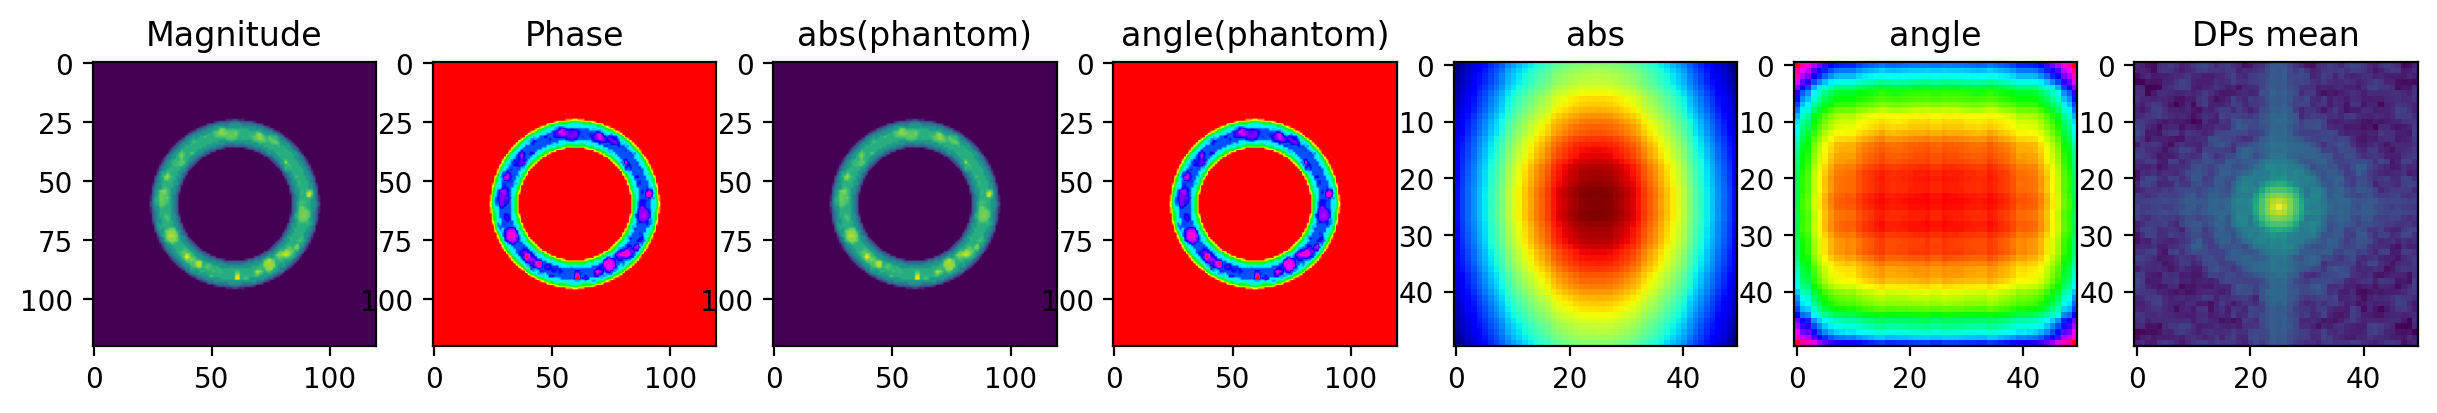

Phantom created at /ibira/lnls/labs/tepui/proposals/20210062/yuri/00000000/data/ptycho3d/complex_phantom/
Energy = 6 keV 	 Wavelength = 0.20664032897701554 nm 	 Wavevector = 30.40638455370665 nm^-1


In [48]:
inputs = {
"path" : "/ibira/lnls/labs/tepui/proposals/20210062/yuri/00000000/data/ptycho3d/complex_phantom/",
"matrix_size": 120, # n of pixels; one side of cube
"n_cpus": 100, # cpu cores
"energy": 6, #keV
"distance": 1, # meter
"detector_pixel": 8*1.25156e-6,
"probe_steps_xy": [10,10], # pixels
"n_of_angles": 0
}

offset = 50
phantom, magnitude, phase, sinogram, probe, data = create_ptycho_phantom(inputs,sample="donut",probe_type="CAT",offset=offset,position_errors=0.5,load=True,preview=True) # run with load = False first; this will create data; then you can run with load = True 

if 0: # dummy sample
    diffraction_patterns, positions, model_obj, model_probe, positions_errors = get_simulated_data(inputs["probe_steps_xy"],random_positions=True,add_position_errors=False)
    """ Experiment Parameters """
    c_speed = 299792458        # Velocity of Light [m/s]
    planck  = 4.135667662E-18  # Plank constant [keV*s]
    position_step = np.max([positions[i]-positions[i-1] for i in range(1,len(positions))])*1e-6
    distance = 30  # meters
    energy = 10    # keV
    n_pixels = 3072
    pixel_size = 55.13e-6  # meters
    wavelength = c_speed * planck / energy
    dx = wavelength*distance/(n_pixels*pixel_size)
    oversampling_ratio = wavelength*distance/(position_step*pixel_size)
    print('Object pixel size:',dx)
    print("Oversampling: ",oversampling_ratio)
    experiment_params = dx, wavelength,distance
    # probe_guess = model_probe*np.exp(-1j*model_probe*2)  
    probe_guess = get_circular_mask(model_probe.shape[0],0.3)
    # probe_guess = np.ones_like(probe_guess) 
    obj_guess = np.ones_like(model_obj) # constant object
    obj_guess = np.random.rand(model_obj.shape[0],model_obj.shape[1])+1j
    
else: # complex phantom
    data_folder = "/ibira/lnls/labs/tepui/proposals/20210062/yuri/00000000/data/ptycho3d/"
    dataname = "complex_phantom"
        
    diffraction_patterns, positions, model_obj, model_probe, obj_pixel_size, wavelength,distance = load_data(data_folder,dataname,offset)

    experiment_params = obj_pixel_size, wavelength,distance
    
    """ Initial guesses """
    object_shape = set_object_size_pxls( positions[:,0], positions[:,1],model_probe.shape,border=offset)
    obj_guess = np.random.rand(object_shape[0],object_shape[1])+1j
    obj_guess = np.ones_like(obj_guess)
    probe_guess = model_probe
    probe_guess = np.ones(model_probe.shape)
    

## Phantom

Energy = 6 keV 	 Wavelength = 0.20664032897701554 nm 	 Wavevector = 30.40638455370665 nm^-1


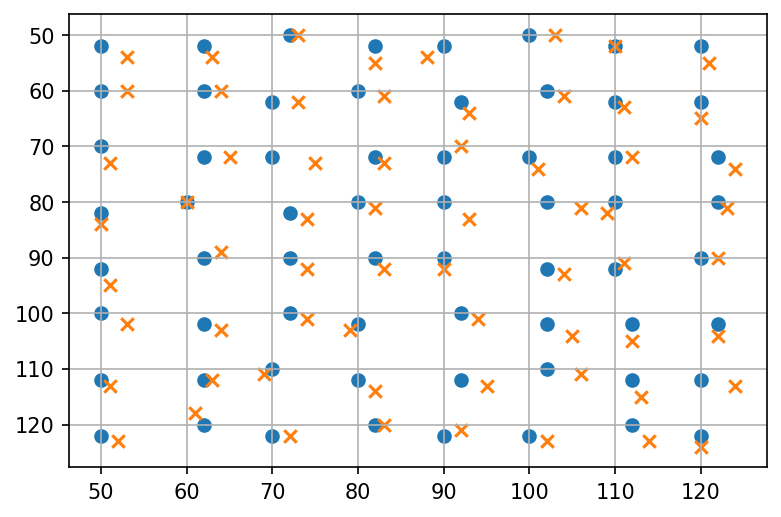

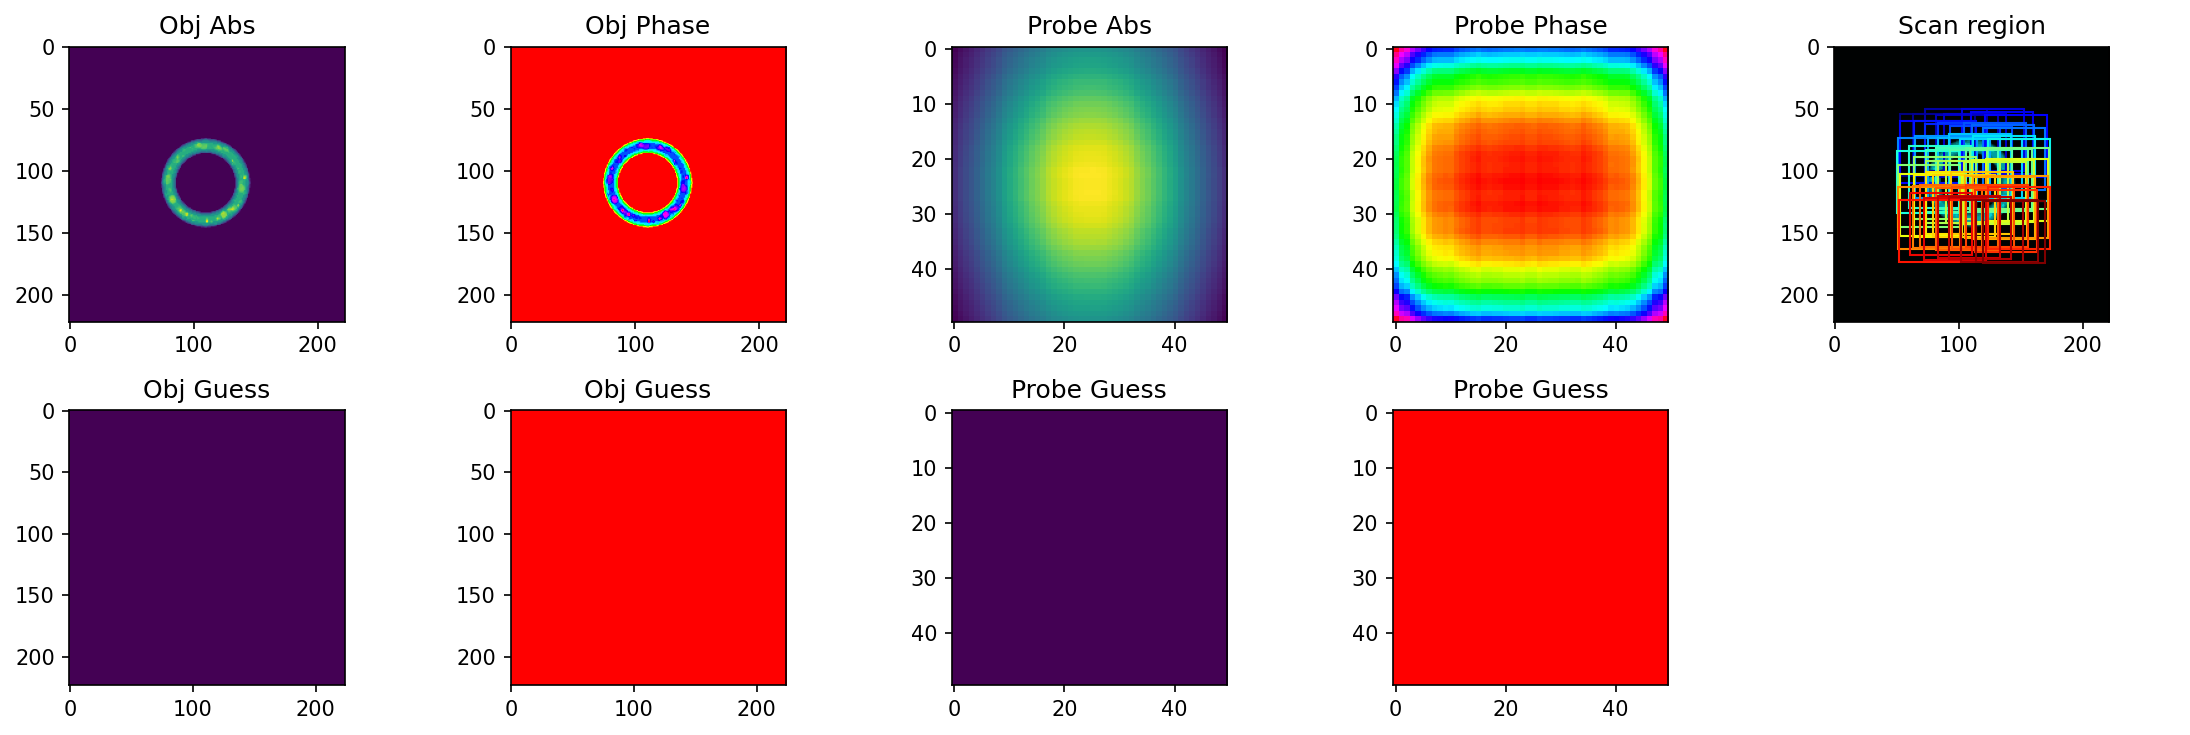

In [51]:
def plot_positions_and_errors(data_folder,dataname,offset,PIE_positions=[]):
    
    import os, json
    
    metadata = json.load(open(os.path.join(data_folder,dataname,'mdata.json')))
    distance = metadata['/entry/beamline/experiment']['distance']*1e-3
    energy = metadata['/entry/beamline/experiment']['energy']
    pixel_size = metadata['/entry/beamline/detector']['pimega']['pixel size']*1e-6
    wavelength, wavevector = calculate_wavelength(energy)
    
    diffraction_patterns = np.load(os.path.join(data_folder,dataname,f"0000_{dataname}_001.hdf5.npy"))

    n_pixels = diffraction_patterns.shape[1]
    obj_pixel_size = wavelength*distance/(n_pixels*pixel_size)
    
    _,_,measured = read_probe_positions_in_pxls(os.path.join(data_folder,dataname),f"0000_{dataname}",obj_pixel_size,offset,0)
    _,_,true = read_probe_positions_in_pxls(os.path.join(data_folder,dataname),f"0000_{dataname}_without_error",obj_pixel_size,offset,0)
    
    colors = np.linspace(0,positions.shape[0]-1,positions.shape[0])
    fig, ax = plt.subplots(dpi=150)
    ax.scatter(true[:,1],true[:,0],marker='o')#,c=colors,cmap='jet')
    ax.scatter(measured[:,1],measured[:,0],marker='x')#,c=np.linspace(0,positions.shape[0]-1,positions.shape[0]),cmap='jet')
    if PIE_positions != []:
        ax.scatter(PIE_positions[:,1],PIE_positions[:,0],marker='*')#,c=np.linspace(0,positions.shape[0]-1,positions.shape[0]),cmap='jet')
        ax.legend(["True" , "Measured", "Corrected"],loc=(1.05,0.84))    
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.grid()


iterations = 150
n_of_modes = 1

plot_positions_and_errors(data_folder,dataname,offset)
plot_guess_and_model(model_obj,model_probe,obj_guess,probe_guess,positions)

Starting PIE...
	Iteration 0/150
	Iteration 50/150
	Iteration 100/150
Starting RAAR...
	Iteration 0/150
	Iteration 50/150
	Iteration 100/150
Starting multiprobe RAAR...
	Iteration 0/150
	Iteration 50/150
	Iteration 100/150
RAAR algorithm ended in 4.685154021950439 seconds
Starting multiprobe PIE algorithm...
	Iteration 0/150
	Iteration 50/150
	Iteration 100/150
PIE algorithm ended in 5.767007254995406 seconds
Energy = 6 keV 	 Wavelength = 0.20664032897701554 nm 	 Wavevector = 30.40638455370665 nm^-1


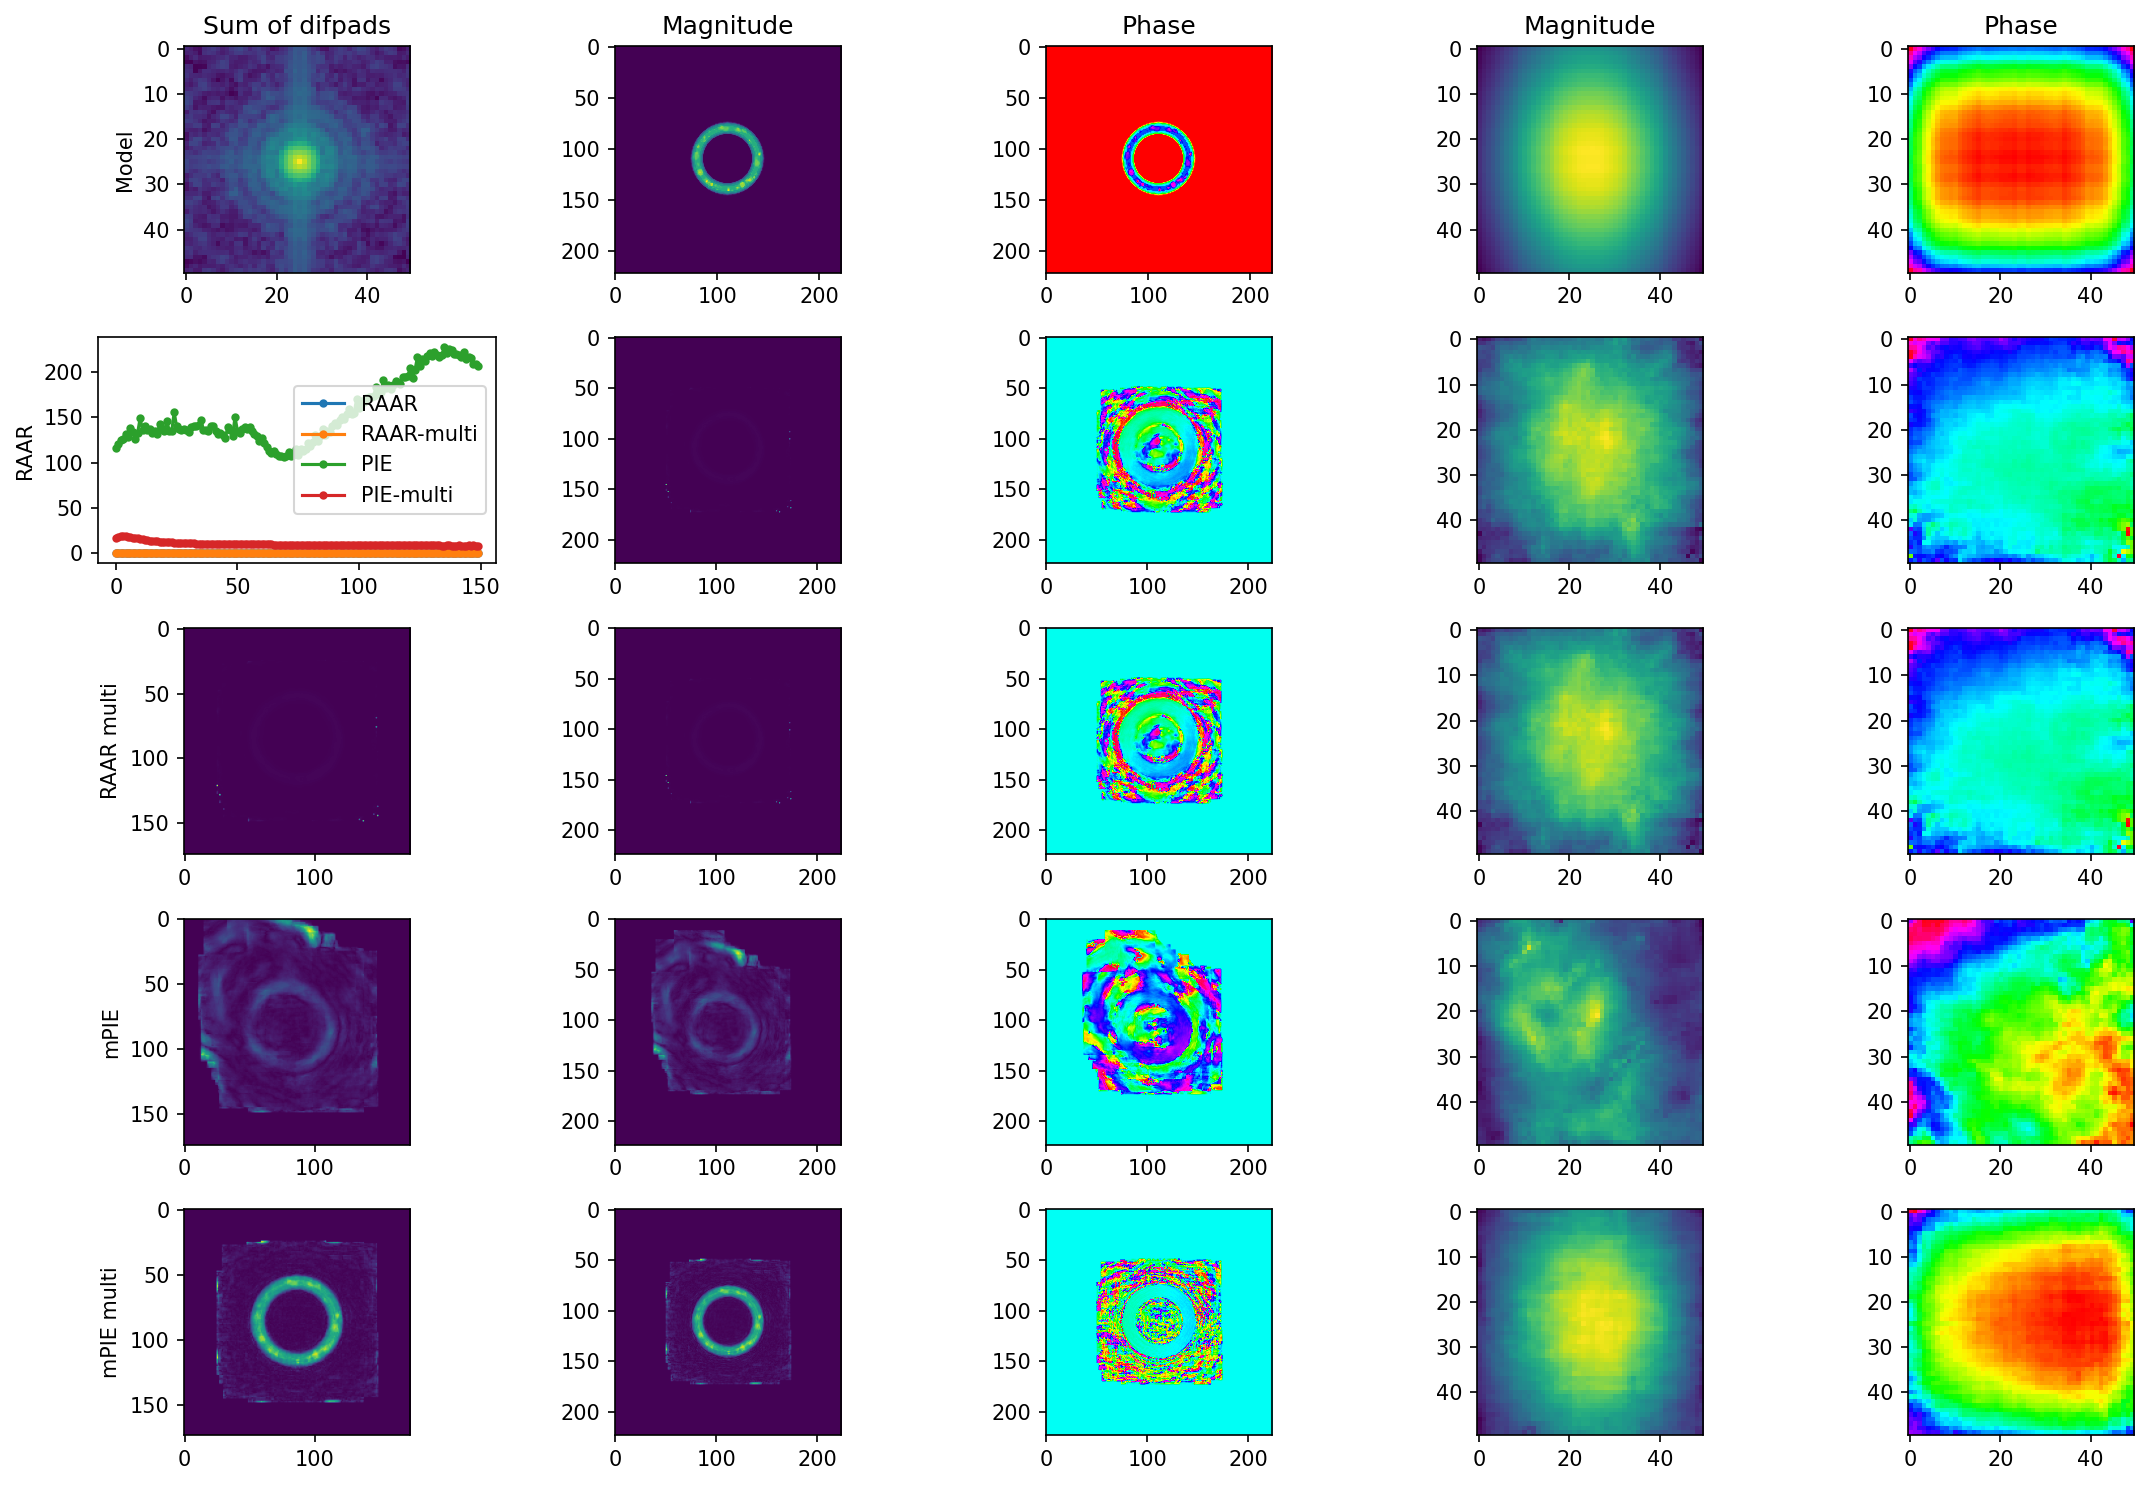

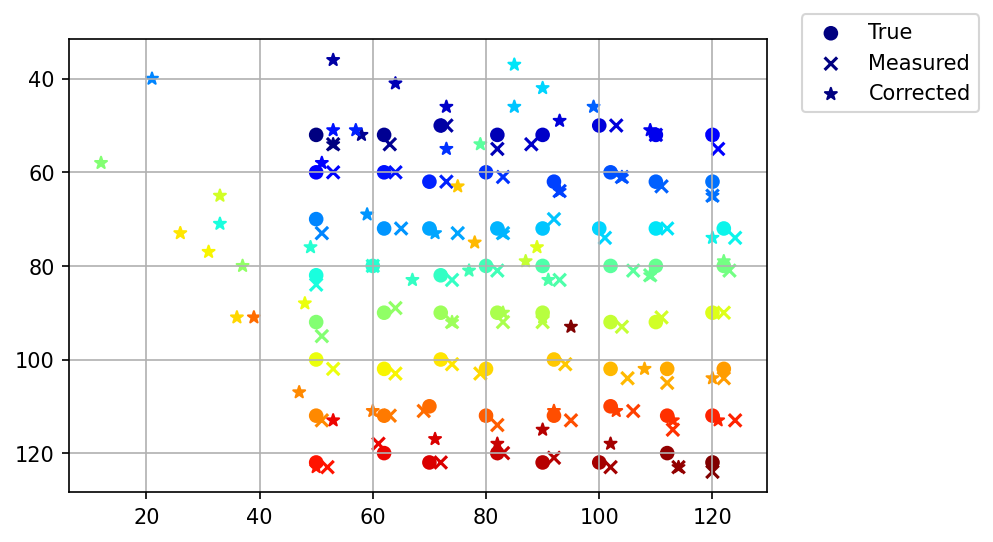

In [50]:
if 1:
    if 1: 
        """ mPIE """
        if 0: # suggested min from paper
            regularization_object, regularization_probe = 0.05, 0.5
            step_object, step_probe = 0.1, 0.2
            friction_object, friction_probe = 0.5, 0.75
            momentum_counter = 10
        elif 0: # suggested max from paper
            regularization_object, regularization_probe = 0.25, 5
            step_object, step_probe = 0.5, 1
            friction_object, friction_probe = 0.9, 0.99
            momentum_counter = 100 
        else: # my params
            regularization_object, regularization_probe = 0.25, 5
            step_object, step_probe = 0.5, 1
            friction_object, friction_probe = 0.9, 0
            momentum_counter = 100 

        centralize_probe = False
        mPIE_params = (regularization_object,regularization_probe,step_object,step_probe,friction_object,friction_probe,momentum_counter)
        PIE_obj, PIE_probe, PIE_positions, PIE_error, PIE_time = mPIE_loop(diffraction_patterns, positions.copy(),obj_guess.copy(),probe_guess, mPIE_params, experiment_params, iterations, model_obj,centralize_probe,beta=25)

    if 1: 
        """ RAAR """
        beta = 0.995
        epsilon = 0.01
        RAAR_params = (beta,epsilon)
        RAAR_obj, RAAR_probe, RAAR_error, RAAR_time = RAAR_loop(diffraction_patterns,positions,obj_guess, probe_guess, RAAR_params,experiment_params, iterations,model_obj)

    if 1:
        """ multiprobe RAAR """
        RAAR_params = (beta,epsilon)
        RAAR2_obj, RAAR2_probes, RAAR2_error, RAAR2_time = RAAR_multiprobe_loop(diffraction_patterns,positions,obj_guess, probe_guess, RAAR_params,experiment_params, iterations,model_obj,n_of_modes=n_of_modes)
        RAAR2_probe = RAAR2_probes[0]


    if 1:
        """ multiprobe mPIE """
        mPIE_params = {}
        mPIE_params["regularization_object"] = regularization_object
        mPIE_params["regularization_probe"]  = regularization_probe
        mPIE_params["step_object"]           = step_object
        mPIE_params["step_probe"]            = step_probe
        mPIE_params["friction_object"]       = friction_object
        mPIE_params["friction_probe"]        = friction_probe
        mPIE_params["momentum_counter"]      = momentum_counter
        PIE2_obj, PIE2_multiprobe, PIE2_error, PIE2_time  = PIE_multiprobe_loop(diffraction_patterns, positions, iterations, mPIE_params, model_obj,n_of_modes = n_of_modes, object_guess=obj_guess.copy(), probe_guess=probe_guess, use_momentum = True)
        PIE2_obj = PIE2_obj[0]
        PIE2_probe = PIE2_multiprobe[0]

    # RAAR2_obj, RAAR2_probe, RAAR2_error, RAAR2_time  = RAAR_obj, RAAR_probe, RAAR_error, RAAR_time    
    # PIE2_obj, PIE2_probe, PIE2_error, PIE2_time = PIE_obj, PIE_probe, PIE_error, PIE_time

    plot_results3(diffraction_patterns,model_obj,model_probe,RAAR_obj, RAAR_probe, RAAR_error, RAAR_time,PIE_obj, PIE_probe, PIE_error, PIE_time,PIE2_obj, PIE2_probe, PIE2_error, PIE2_time, RAAR2_obj, RAAR2_probe, RAAR2_error, RAAR2_time, axis=True )

# plot_probe_modes(RAAR2_probes)
# plot_probe_modes(PIE2_multiprobe)

plot_positions_and_errors(data_folder,dataname,offset,PIE_positions)